In [1]:
import numpy as np
import porepy as pp
import scipy.sparse as sps
import sys
sys.path.append("./class")
from Flow_class import Flow
from Transport_class import Transport
from Reaction_class import Reaction

In [2]:
mesh_args = {"mesh_size_frac": 0.15, "mesh_size_bound": 0.15}
gb, domain = pp.grid_buckets_2d.benchmark_regular(mesh_args)

In [3]:
parameter={"aperture":1e-3,
          "fracture_perm":1e4,
          "perm":1,
          #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          "bc_value":[0.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

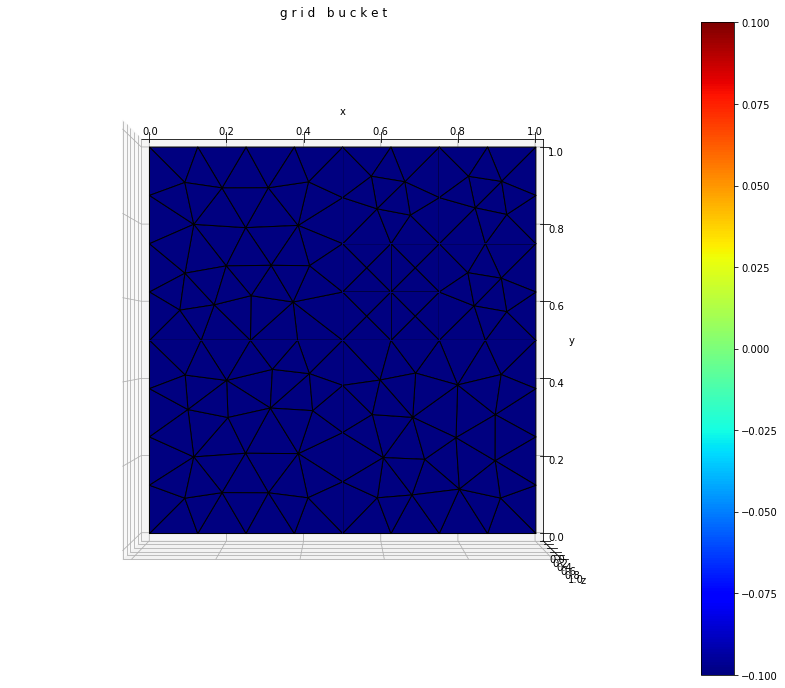

In [4]:
flow=Flow(gb,domain,parameter)
flow.add_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

In [5]:
#for g,d in gb:
    #d[pp.STATE]["pressure"]=0.0*d[pp.STATE]["pressure"]

#flow.plot_pressure()

In [6]:
parameter={
    "aperture":1e-4,
    "por":0.2,
    "por_frac":0.8,
    #"time_step":1 / 60,
    "time_step":34.56,
    #"t_max":1 /3,
    "t_max":345600,
    "initial_cond":lambda x,y,z:0.0}
Ca_value=[0.0,0.0]
Ca_type=['dir','dir']
#CaSiO3_value=[1.0,0.0]
CaSiO3_value=[0.0,0.0]
CaSiO3_type=['dir','dir']
Ca="Ca"
CaSiO3="CaSiO3"

transport=Transport(gb,domain,parameter)

In [7]:
reaction_data={"temperature":423,
       "A":1.9e-2,
       "rate_const":0.004466,
       #"rate_const":0.0,
       "E":4700,
       "R":8.314,
       "K_eq":10e9,
       "ph":3.5,
       "mass_weight":1}
reaction=Reaction(reaction_data)
reaction.set_const_rate()

In [1]:
transport.set_data(Ca_value,Ca_type,Ca)
transport.get_flux(Ca)
for g,d in gb:
    #d[pp.PARAMETERS]["Ca"]["darcy_flux"]=0.0*d[pp.PARAMETERS]["Ca"]["darcy_flux"]
    print("velocity")
    print(d[pp.PARAMETERS]["Ca"]["darcy_flux"])
transport.discretize(Ca)
#reaction.compute_rd(gb,Ca)#Con Questa formulazione poi dovrei passare gb anche alla funzione successiva
#transport.compute_rd(reaction_data,Ca)
lhs_Ca,rhs_source_adv_Ca,rhs_mass_Ca,assembler_Ca=transport.get_transport_lhs_rhs(Ca)#,gb
transport.set_data(CaSiO3_value,CaSiO3_type,CaSiO3)
transport.get_flux(CaSiO3)
for g,d in gb:
    #d[pp.PARAMETERS]["CaSiO3"]["darcy_flux"]=0.0*d[pp.PARAMETERS]["CaSiO3"]["darcy_flux"]
    print("velocity")
    print(d[pp.PARAMETERS]["Ca"]["darcy_flux"])
    
transport.discretize(CaSiO3)
lhs_CaSiO3,rhs_source_adv_CaSiO3,rhs_mass_CaSiO3,assembler_CaSiO3=transport.get_transport_lhs_rhs(CaSiO3)

NameError: name 'transport' is not defined

In [9]:
#volumes=np.array([])
#for g,d in gb:
    #for i in range(g.num_cells):
        #volumes=np.append(volumes,g.cell_volumes[i])
#for i in range(rhs_source_adv_CaSiO3.size-rhs.size):
    #volumes=np.append(rhs,0)

In [10]:
save_every = 1
n_steps = int(np.round(parameter["t_max"] / parameter["time_step"]))

# Initial condition
tracer1 = np.zeros(rhs_source_adv_Ca.size)
assembler_Ca.distribute_variable(
    tracer1, variable_names=[Ca,transport.mortar_variable]
)

tracer2 = 16.7504*np.ones(rhs_source_adv_CaSiO3.size)
assembler_CaSiO3.distribute_variable(
    tracer2, variable_names=[CaSiO3,transport.mortar_variable]
)


# Exporter
exporter1 = pp.Exporter(gb, file_name="Ca", folder_name="Ca")
export_field1 = ["Ca"]
IEsolver_Ca = sps.linalg.factorized(lhs_Ca)

exporter2= pp.Exporter(gb, file_name="CaSiO3", folder_name="CaSiO3")
export_field2 = ["CaSiO3"]
IEsolver_CaSiO3 = sps.linalg.factorized(lhs_CaSiO3)

/home/dell/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [2]:
rd=np.zeros(tracer1.size)
for i in range(n_steps):
#for i in range(100):
    
    #for g,d in gb:
        #print("Ca")
        #print(d[pp.STATE]["Ca"])
        #print("CaSiO3")
        #print(d[pp.STATE]["CaSiO3"])
    #print("FINE")
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        rd=reaction.compute_rd(tracer1,rd)
        #print(rd)
        #print(rhs_mass_Ca*rd)
        assembler_Ca.distribute_variable(
        tracer1,
        variable_names=[Ca,transport.mortar_variable],
    )
        exporter1.write_vtu(export_field1, time_step=int(i // save_every))
        
        assembler_CaSiO3.distribute_variable(
        tracer2,
        variable_names=[CaSiO3,transport.mortar_variable],
    )
        exporter2.write_vtu(export_field2, time_step=int(i // save_every))
    tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca+rhs_mass_Ca*rd*tracer2*parameter["time_step"])
    tracer2 = IEsolver_CaSiO3(rhs_mass_Ca * tracer2 + rhs_source_adv_CaSiO3-rhs_mass_CaSiO3*rd*tracer2*parameter["time_step"])
    #tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca)
    #tracer2 = IEsolver_CaSiO3(rhs_mass_Ca * tracer2 + rhs_source_adv_CaSiO3)
    
for g,d in gb:
    print("CaSiO3")
    print(d[pp.STATE]["CaSiO3"])
    print("Ca")
    print(d[pp.STATE]["Ca"])
    print("FINE")
    
    
exporter1.write_vtu(export_field1, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
    
exporter2.write_vtu(export_field2, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
exporter1.write_pvd(time_steps)
exporter2.write_pvd(time_steps)
transport.plot_tracer(Ca)
transport.plot_tracer(CaSiO3)


NameError: name 'np' is not defined

In [12]:
#for g,d in gb:
    #print("Ca")
    #print(d[pp.STATE]["Ca"])
    #print("CaSiO3")
    #print(d[pp.STATE]["CaSiO3"])
    #print("FINE")